# 학습 목표
1. 리간드 기반 가상 스크리닝(LBVS)의 원리와 방법론 이해하기
2. PubChem의 SARS-CoV-2 3CL protease 데이터를 활용한 LBVS 모델 구축하기
3. 분자 지문(Fingerprint)과 유사성 측정 방법 학습하기
4. 머신러닝 기반 활성 화합물 분류 모델 개발하기

Rifaioglu, A. S., Nalbat, E., Atalay, V., Martin, M. J., Cetin-Atalay, R., & Doğan, T. (2020). DEEPScreen: high performance drug–target interaction prediction with convolutional neural networks using 2-D structural compound representations. Chemical science, 11(9), 2531-2557.

https://pubs.rsc.org/en/content/articlehtml/2020/sc/c9sc03414e

<img src='https://pubs.rsc.org/image/article/2020/SC/c9sc03414e/c9sc03414e-f1_hi-res.gif'>

# 1. 리간드 기반 가상 스크리닝(LBVS)
- 리간드 기반 가상 스크리닝(Ligand-Based Virtual Screening, LBVS)은 타겟 단백질의 3D 구조 정보 없이, 이미 알려진 활성 리간드(화합물)의 특성을 기반으로 새로운 활성 화합물을 발굴하는 계산 기법
- LBVS는 "유사한 화합물은 유사한 활성을 가진다"는 유사성 원리(Similarity Principle)에 기반함.

# 2. 3CL Protease 데이터
- SARS-CoV-2의 3CL protease(주 단백질분해효소, Main Protease, Mpro)는 바이러스 복제에 필수적인 효소로, COVID-19 치료제 개발의 주요 타겟
- 이 효소는 바이러스 폴리단백질을 기능적 단백질로 절단하는 역할을 하며, 인간 단백질분해효소와 구조적으로 다르기 때문에 선택적 억제제 개발에 적합

# 3. 실습

## 3.1. 라이브러리 설치 및 불러오기

In [ ]:
# 필요 라이브러리 설치
!pip install rdkit

# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import io
import os
from tqdm import tqdm

## 3.2. 데이터 불러오기

In [ ]:
# 데이터 로드
def load_3clpro_data():
    """
    3CL Protease 데이터 로드
    """
    df = pd.read_csv('3clpro.csv')
    print(f"Loaded {len(df)} compounds from 3clpro.csv")
    return df

# 데이터 로드
data_df = load_3clpro_data()

# 데이터 확인
print("\nData preview:")
print(data_df.head())

# 활성/비활성 화합물 분포
print("\nActivity distribution:")
print(data_df['label'].value_counts())

Loaded 101 compounds from 3clpro.csv

Data preview:
   Unnamed: 0                                             smiles  label
0           0    COC1=CC=C(C=C1)C(=O)N2C3=CC4=C(C=C3N=C2SC)OCCO4      1
1           1     COC1=C(C=C(C=C1)C2CC(=NN2C(=O)CCl)C3=CC=CS3)OC      1
2           2  CCC(C)C1=CC=C(C=C1)N(C(C2=CN=CC=C2)C(=O)NC3CCC...      1
3           3  COC1=C(C=CC(=C1)C2CC(=NN2C(=O)CCl)C3=CC=CS3)OC...      1
4           4          CCC1=CC(=O)OC2=C1C=CC(=C2)OC(=O)C3=CC=CO3      1

Activity distribution:
label
0    57
1    44
Name: count, dtype: int64


## 3.3. 데이터 전처리(분자 이미지 만들기)

In [ ]:
# 분자 이미지 생성 및 저장 함수
def generate_molecule_images(df, img_size=(224, 224), img_dir='molecule_images'):
    # 이미지 저장 디렉토리 생성
    os.makedirs(img_dir, exist_ok=True)

    # 이미지 경로 열 추가
    df['img_path'] = ''

    # 유효하지 않은 SMILES 인덱스
    invalid_indices = []

    # 각 SMILES에 대해 분자 이미지 생성
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Generating molecule images"):
        try:
            # SMILES를 RDKit 분자 객체로 변환
            mol = Chem.MolFromSmiles(row['smiles'])

            if mol is None:
                invalid_indices.append(i)
                continue

            # 이미지 파일 경로
            img_path = os.path.join(img_dir, f"mol_{i}.png")

            # 분자 이미지 생성 및 저장
            img = Draw.MolToImage(mol, size=img_size)
            img.save(img_path)

            # 이미지 경로 저장
            df.at[i, 'img_path'] = img_path

        except Exception as e:
            print(f"Error generating image for index {i}: {e}")
            invalid_indices.append(i)

    # 유효하지 않은 SMILES 제거
    if invalid_indices:
        print(f"Removing {len(invalid_indices)} invalid SMILES")
        df = df.drop(invalid_indices).reset_index(drop=True)

    return df

# 분자 이미지 생성
data_df = generate_molecule_images(data_df)
data_df

Generating molecule images: 100%|██████████| 101/101 [00:01<00:00, 65.23it/s]


,Unnamed: 0,smiles,label,img_path
0,0,COC1=CC=C(C=C1)C(=O)N2C3=CC4=C(C=C3N=C2SC)OCCO4,1,molecule_images/mol_0.png
1,1,COC1=C(C=C(C=C1)C2CC(=NN2C(=O)CCl)C3=CC=CS3)OC,1,molecule_images/mol_1.png
2,2,CCC(C)C1=CC=C(C=C1)N(C(C2=CN=CC=C2)C(=O)NC3CCC...,1,molecule_images/mol_2.png
3,3,COC1=C(C=CC(=C1)C2CC(=NN2C(=O)CCl)C3=CC=CS3)OC...,1,molecule_images/mol_3.png
4,4,CCC1=CC(=O)OC2=C1C=CC(=C2)OC(=O)C3=CC=CO3,1,molecule_images/mol_4.png
...,...,...,...,...
96,96,C1=CC=C2C(=C1)C(=C(N2)C(=O)O)C(C3=C(C=CC(=C3)B...,0,molecule_images/mol_96.png
97,97,CCN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=CC=C3)C,0,molecule_images/mol_97.png
98,98,CC1=CC(=NO1)NC(=O)COC(=O)C(C(C)C)NC2=C(C=C(C=C...,0,molecule_images/mol_98.png
99,99,COC1=CC=C(C=C1)C(=O)OC2=CN=CC=C2,0,molecule_images/mol_99.png


## 3.4. 데이터셋 클래스 정의 및 전처리

In [ ]:
# PyTorch 데이터셋 클래스
class MoleculeImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Parameters:
        - dataframe: 이미지 경로와 레이블이 있는 데이터프레임
        - transform: 이미지 변환 함수
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        label = self.dataframe.iloc[idx]['label']

        # 이미지 로드
        image = Image.open(img_path).convert('RGB')

        # 이미지 변환 적용
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# 데이터 분할 및 전처리
def prepare_data(df, test_size=0.2, val_size=0.2, random_state=42):
    # 학습/테스트 분할
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df['label'])

    # 학습/검증 분할
    train_df, val_df = train_test_split(
        train_df, test_size=val_size, random_state=random_state, stratify=train_df['label'])

    print(f"Data split - Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    # 이미지 변환 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 데이터셋 생성
    train_dataset = MoleculeImageDataset(train_df, transform=transform)
    val_dataset = MoleculeImageDataset(val_df, transform=transform)
    test_dataset = MoleculeImageDataset(test_df, transform=transform)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    return train_loader, val_loader, test_loader, test_df

# 데이터 준비
train_loader, val_loader, test_loader, test_df = prepare_data(data_df)

Data split - Train: 64, Validation: 16, Test: 21


## 3.5. 모델 정의 및 학습

In [ ]:
# CNN 모델 정의
class MoleculeCNN(nn.Module):
    def __init__(self):
        super(MoleculeCNN, self).__init__()

        # 컨볼루션 레이어
        self.conv_layers = nn.Sequential(
            # 첫 번째 컨볼루션 블록
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 두 번째 컨볼루션 블록
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 세 번째 컨볼루션 블록
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 네 번째 컨볼루션 블록
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 완전 연결 레이어
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 컨볼루션 레이어 통과
        x = self.conv_layers(x)

        # 완전 연결 레이어를 위한 형태 변환
        x = x.view(x.size(0), -1)

        # 완전 연결 레이어 통과
        x = self.fc_layers(x)

        return x

Using device: cpu


Epoch 1/5 - Validation: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


Epoch 1/5, Train Loss: 4.1569, Val Loss: 0.6735, Val Accuracy: 0.5625
Best model saved with accuracy: 0.5625


Epoch 2/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


Epoch 2/5, Train Loss: 0.9849, Val Loss: 0.9802, Val Accuracy: 0.4375


Epoch 3/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Epoch 3/5, Train Loss: 1.5677, Val Loss: 1.4680, Val Accuracy: 0.5625


Epoch 4/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Epoch 4/5, Train Loss: 1.7846, Val Loss: 1.1463, Val Accuracy: 0.3125


Epoch 5/5 - Validation: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Epoch 5/5, Train Loss: 0.9220, Val Loss: 1.1718, Val Accuracy: 0.3750


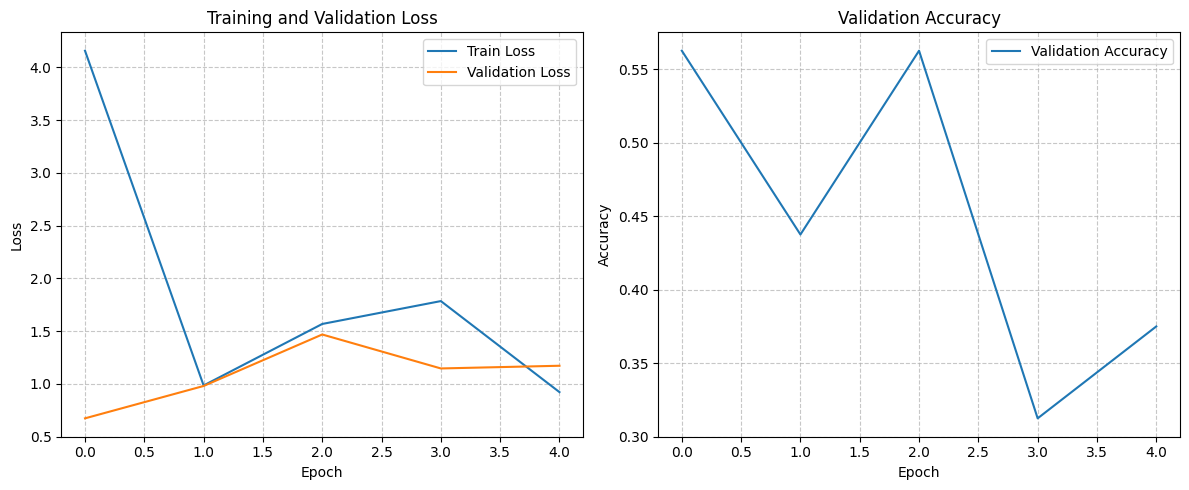

Evaluating: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]



Model Performance:
Accuracy: 0.5238
Precision: 0.4444
Recall: 0.4444
F1 Score: 0.4444
ROC AUC: 0.6111

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.58      0.58        12
         1.0       0.44      0.44      0.44         9

    accuracy                           0.52        21
   macro avg       0.51      0.51      0.51        21
weighted avg       0.52      0.52      0.52        21



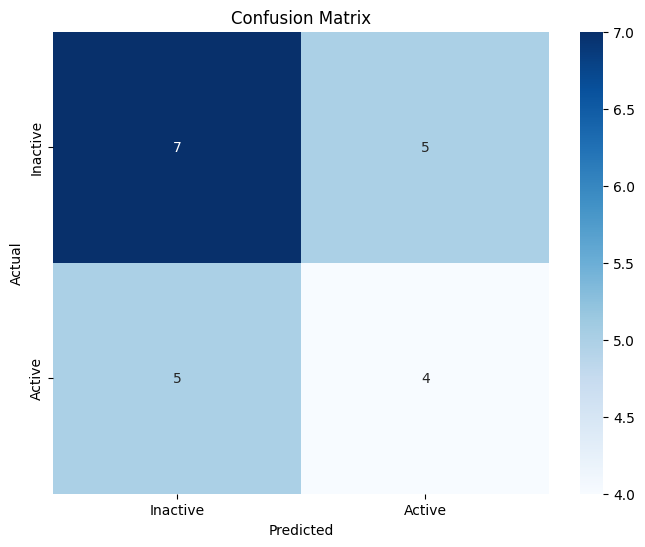

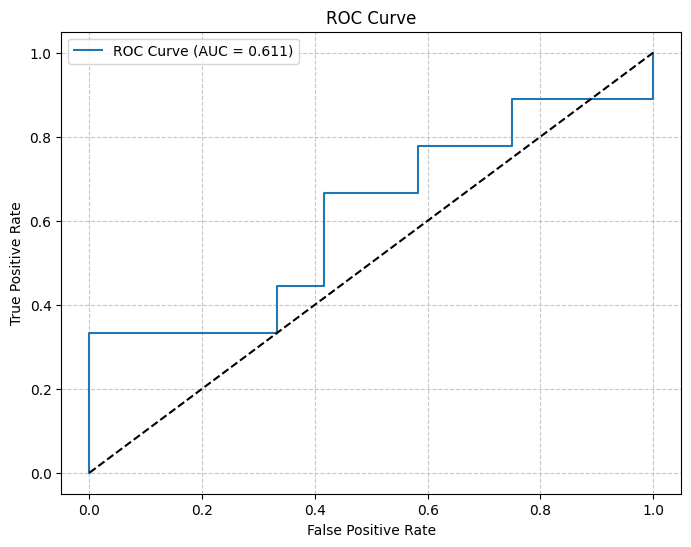

Model saved to 'molecule_cnn_model.pt'


In [ ]:
# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50):
    # 학습 이력
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    # 최적 모델 저장
    best_val_accuracy = 0.0
    best_model_state = None

    # 학습 루프
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        train_loss = 0.0

        # 학습 데이터 처리
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # 에폭 평균 학습 손실
        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_correct = 0

        # 검증 데이터 처리
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                labels = labels.to(device).unsqueeze(1)

                # 순전파
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

                # 예측 정확도 계산
                predicted = (outputs >= 0.5).float()
                val_correct += (predicted == labels).sum().item()

        # 에폭 평균 검증 손실 및 정확도
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)

        # 진행 상황 출력
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

        # 최적 모델 저장
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
            print(f"Best model saved with accuracy: {val_accuracy:.4f}")

    # 최적 모델 상태 복원
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, history

# 모델 평가 함수
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)

            # 예측
            outputs = model(images)

            # 예측 및 레이블 저장
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 예측값 변환
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels)

    # 이진 분류 예측 (임계값 0.5)
    binary_preds = (all_preds >= 0.5).astype(int)

    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, binary_preds)
    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)

    # 결과 출력
    print("\nModel Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # 분류 보고서
    print("\nClassification Report:")
    print(classification_report(all_labels, binary_preds))

    # 혼동 행렬
    cm = confusion_matrix(all_labels, binary_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Inactive', 'Active'],
                yticklabels=['Inactive', 'Active'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # ROC 곡선
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('roc_curve.png')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_preds,
        'labels': all_labels
    }

# 학습 이력 시각화 함수
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# 모델 초기화 및 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MoleculeCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
trained_model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

# 학습 이력 시각화
plot_training_history(history)

# 모델 평가
test_metrics = evaluate_model(trained_model, test_loader, device)

# 모델 저장
torch.save(trained_model.state_dict(), 'molecule_cnn_model.pt')
print("Model saved to 'molecule_cnn_model.pt'")

## 3.6. 가상 스크리닝

In [ ]:
!wget http://files.docking.org/2D/AA/AAAA.smi
vs_df = pd.read_csv('AAAA.smi', sep=' ')
vs_df

--2025-03-29 16:22:25--  http://files.docking.org/2D/AA/AAAA.smi
Resolving files.docking.org (files.docking.org)... 169.230.75.4
Connecting to files.docking.org (files.docking.org)|169.230.75.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86110 (84K) [application/smil+xml]
Saving to: ‘AAAA.smi’

AAAA.smi            100%[===================>]  84.09K   375KB/s    in 0.2s    

2025-03-29 16:22:26 (375 KB/s) - ‘AAAA.smi’ saved [86110/86110]



,smiles,zinc_id
0,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O,4371221
1,NC(=O)N[C@@H]1NC(=O)NC1=O,1843030
2,NC(=O)CN1CCC(N)CC1,9256947
3,CNC(=O)c1n[nH]c(N)n1,19844301
4,NC(=O)[C@H]1[C@H]2C=C[C@@H](O2)[C@@H]1N,242677143
...,...,...
2400,O=C1C[C@H](C(=O)O)NC(=O)N1,895194
2401,O=C1CC(=C2CNC2)C(=O)N1,1772715943
2402,N=C(N)NCCC[C@H](N)C(N)=O,1737947
2403,Nc1n[nH]c(N)n1,4118774


In [ ]:
# 가상 스크리닝: 외부 화합물 라이브러리 평가
def virtual_screening(model, vs_df, device, batch_size=32, img_size=(224, 224), temp_dir='vs_images'):
    # 임시 디렉토리 생성
    os.makedirs(temp_dir, exist_ok=True)

    # 이미지 변환 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 결과 데이터프레임 준비
    result_df = vs_df.copy()
    result_df['activity_prob'] = 0.0
    result_df['predicted_class'] = 0
    result_df['valid_smiles'] = True

    # 모델을 평가 모드로 설정
    model.eval()

    # 배치 처리를 위한 준비
    total_compounds = len(vs_df)
    num_batches = (total_compounds + batch_size - 1) // batch_size

    print(f"Starting virtual screening of {total_compounds} compounds...")

    for batch_idx in tqdm(range(num_batches), desc="Screening compounds"):
        # 배치 인덱스 계산
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, total_compounds)
        batch_df = vs_df.iloc[start_idx:end_idx]

        # 배치 이미지 생성 및 로드
        batch_images = []
        valid_indices = []

        for i, (idx, row) in enumerate(batch_df.iterrows()):
            try:
                # SMILES를 RDKit 분자 객체로 변환
                mol = Chem.MolFromSmiles(row['smiles'])

                if mol is None:
                    print(f"Invalid SMILES at index {idx}: {row['smiles']}")
                    result_df.at[idx, 'valid_smiles'] = False
                    continue

                # 이미지 파일 경로
                img_path = os.path.join(temp_dir, f"vs_mol_{idx}.png")

                # 분자 이미지 생성 및 저장
                img = Draw.MolToImage(mol, size=img_size)
                img.save(img_path)

                # 이미지 로드 및 변환
                image = Image.open(img_path).convert('RGB')
                image = transform(image)

                batch_images.append(image)
                valid_indices.append(idx)

            except Exception as e:
                print(f"Error processing compound at index {idx}: {e}")
                result_df.at[idx, 'valid_smiles'] = False

        # 배치 예측
        if batch_images:
            # 이미지 배치를 텐서로 변환
            batch_tensor = torch.stack(batch_images).to(device)

            # 예측
            with torch.no_grad():
                outputs = model(batch_tensor)
                probs = outputs.cpu().numpy().flatten()

            # 결과 저장
            for idx, prob in zip(valid_indices, probs):
                result_df.at[idx, 'activity_prob'] = float(prob)
                result_df.at[idx, 'predicted_class'] = 1 if prob >= 0.5 else 0

    # 활성 예측 레이블 추가
    result_df['prediction'] = result_df['predicted_class'].map({1: 'Active', 0: 'Inactive'})

    # 활성 확률 기준으로 정렬
    result_df = result_df.sort_values('activity_prob', ascending=False).reset_index(drop=True)

    # 결과 요약
    total_valid = result_df['valid_smiles'].sum()
    total_active = (result_df['predicted_class'] == 1).sum()

    print(f"\nVirtual screening completed:")
    print(f"Total compounds: {total_compounds}")
    print(f"Valid SMILES: {total_valid} ({total_valid/total_compounds*100:.1f}%)")
    print(f"Predicted active: {total_active} ({total_active/total_valid*100:.1f}% of valid compounds)")

    return result_df

# 상위 활성 화합물 시각화
def visualize_top_hits(vs_results, n_compounds=10):
    # 활성 예측 화합물만 선택
    active_df = vs_results[vs_results['predicted_class'] == 1]

    if len(active_df) == 0:
        print("No active compounds predicted.")
        return

    # 상위 n개 화합물 선택
    top_df = active_df.head(n_compounds)

    # 분자 객체 생성
    mols = []
    legends = []

    for _, row in top_df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol:
            mols.append(mol)
            legends.append(f"ZINC: {row['zinc_id']}\nProb: {row['activity_prob']:.3f}")

    # 분자 이미지 생성
    if mols:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=5,
            subImgSize=(300, 300),
            legends=legends
        )
        display(img)

    # 결과 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(vs_results['activity_prob'], bins=50, alpha=0.7)
    plt.axvline(x=0.5, color='red', linestyle='--', label='Activity Threshold (0.5)')
    plt.title('Distribution of Predicted Activity Probabilities')
    plt.xlabel('Activity Probability')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig('activity_distribution.png')
    plt.show()

# 가상 스크리닝 실행
def run_virtual_screening(model_path, vs_df):
    # 장치 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 모델 로드
    model = MoleculeCNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")

    # 가상 스크리닝 실행
    vs_results = virtual_screening(model, vs_df, device)

    # 상위 활성 화합물 시각화
    visualize_top_hits(vs_results)

    # 결과 저장
    vs_results.to_csv('virtual_screening_results.csv', index=False)
    print("Results saved to 'virtual_screening_results.csv'")

    return vs_results

Using device: cpu
Model loaded from molecule_cnn_model.pt
Starting virtual screening of 2405 compounds...


Screening compounds: 100%|██████████| 76/76 [03:58<00:00,  3.13s/it]


Virtual screening completed:
Total compounds: 2405
Valid SMILES: 2405 (100.0%)
Predicted active: 627 (26.1% of valid compounds)


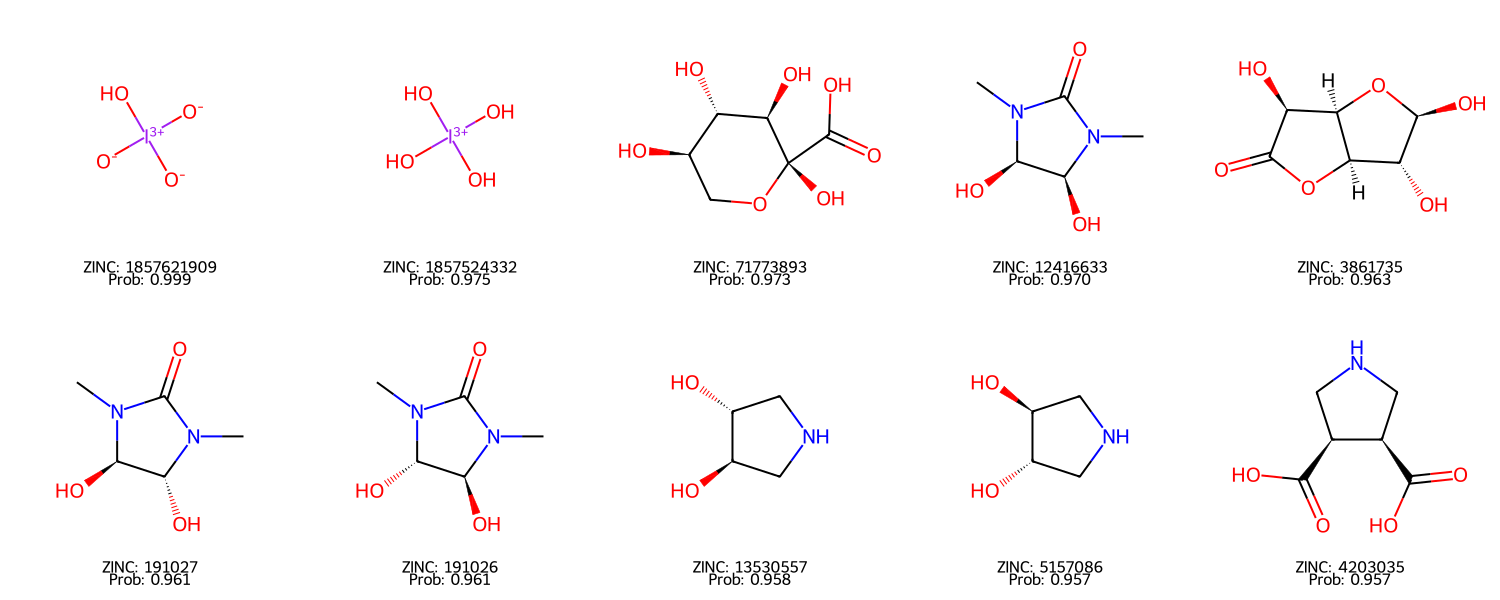

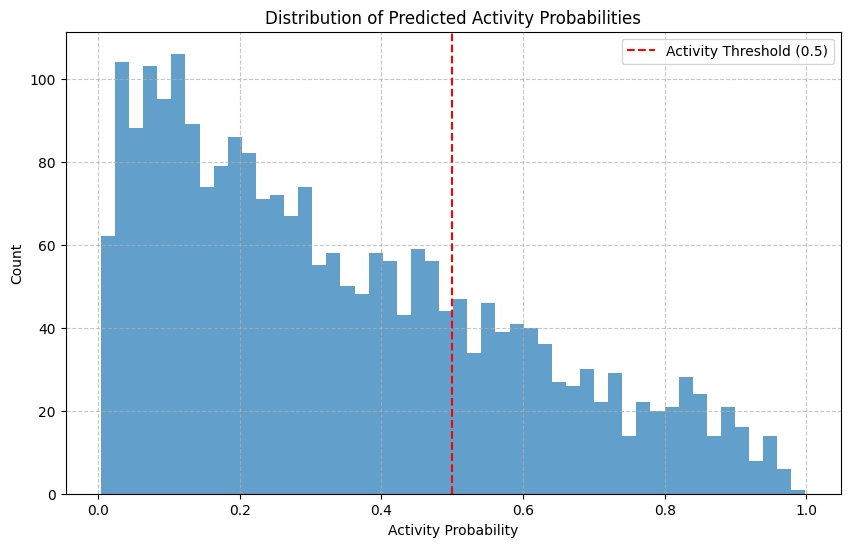

Results saved to 'virtual_screening_results.csv'

Top 10 Virtual Screening Hits:
      zinc_id                                        smiles  activity_prob  \
0  1857621909                        [O-][I+3]([O-])([O-])O       0.998695   
1  1857524332                                 O[I+3](O)(O)O       0.974853   
2    71773893      O=C(O)[C@]1(O)OC[C@@H](O)[C@H](O)[C@H]1O       0.973482   
3    12416633                  CN1C(=O)N(C)[C@H](O)[C@@H]1O       0.969648   
4     3861735  O=C1O[C@H]2[C@H](O[C@@H](O)[C@@H]2O)[C@@H]1O       0.962837   
5      191027                   CN1C(=O)N(C)[C@H](O)[C@H]1O       0.961441   
6      191026                 CN1C(=O)N(C)[C@@H](O)[C@@H]1O       0.960873   
7    13530557                            O[C@@H]1CNC[C@H]1O       0.957653   
8     5157086                            O[C@H]1CNC[C@@H]1O       0.957219   
9     4203035                 O=C(O)[C@@H]1CNC[C@@H]1C(=O)O       0.956666   

  prediction  
0     Active  
1     Active  
2     Active  


In [ ]:
# 가상 스크리닝 실행
model_path = 'molecule_cnn_model.pt'
vs_results = run_virtual_screening(model_path, vs_df)

# 상위 10개 히트 출력
print("\nTop 10 Virtual Screening Hits:")
print(vs_results.head(10)[['zinc_id', 'smiles', 'activity_prob', 'prediction']])

## 3.7. 확인
https://zinc.docking.org/substances/ZINC000071773893/